<a href="https://colab.research.google.com/github/kaluznys/uczenie_maszynowe_UW/blob/main/praca_domowa_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework Assignment: Optimizing the Classification Threshold in Logistic Regression**

-------------------------------

In this assignment, you will explore the concept of **classification thresholds** in **Logistic Regression** and investigate whether the commonly used threshold of **0.5** is always the optimal choice. To complete this assignment, you will need to conduct **additional reading** on **ROC curves** and the **AUC metric**, beyond the materials covered in class.

This exercise focuses on the **importance of threshold selection** and how it impacts model performance based on different evaluation criteria.



## **The Objective**

**Is a 0.5 threshold always the best choice in Logistic Regression?**

- Analyze if the standard threshold of **0.5** always yields the most desirable results in various scenarios.
- Investigate alternative thresholds and how they can improve model performance depending on the problem context.



## **Helper Questions**

1. **Would a different threshold yield better results?**  
   - How does shifting the threshold affect the **trade-off between sensitivity and specificity**?

2. **How do you define "better" results?**  
   - Is **higher specificity** more valuable than **higher sensitivity** in certain contexts? Or maybe the other way around?
   - Does the **best threshold** depend on the task? (discuss cases like *disease detection* vs. *spam filtering*)

3. **How does a ROC curve help in this process?**  
   - Learn how to use a **ROC curve** to visualize the trade-off between **True Positive Rate (Sensitivity)** and **False Positive Rate (1 - Specificity)**.

4. **How do you select the optimal threshold using the ROC curve?**  
   - Discuss strategies to select a threshold depending on the specific task at hand and the acceptable **trade-off between sensitivity and specificity**.

5. **What is the AUC metric and how is it useful?**  
   - Define **AUC (Area Under the Curve)** and discuss its role in evaluating the overall performance of a classifier.



## **Tasks & Deliverables**

1. **Colab Notebook**
   - Select a suitable classification 2-class dataset.
   - Divide the dataset into three parts: **train**, **validation**, and **test**.
   - Train the **Logistic Regression** model on the **training** set.
   - Use the **validation** set to:
     - Plot the **ROC curve**.
     - Calculate the **AUC**.
     - Determine the **optimal threshold** using the ROC curve for your dataset.
   - Apply the selected threshold to the **test** set to evaluate final model performance using metrics like:
     - **Accuracy**
     - **Precision & Recall**
     - **F1-Score**
     - **Specificity & Sensitivity**

2. **Answer the Questions:**
   - Use markdown cells to provide explanations.
   - Answer all helper questions with supporting evidence from your plots and results.

3. **Visualizations:**
   - **ROC curve** based on the **validation** set with threshold points marked.
   - Highlight the **optimal threshold** on the ROC curve.

4. **Publish on GitHub**  
   - Place the Colab notebook in your **GitHub repository** for this course.
   - In your repository’s **README**, add a **link** to the notebook and also include an **“Open in Colab”** badge at the top of the notebook so it can be launched directly from GitHub.




In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Eksperymenty przeprowadzę na 3 zbiorach danych. Jak się okaże dwa pierwsze zbiory są łatwe do modelowania (szczególnie pierwszy), ale ukażą ekstremalne przypadki, natomiast ostatni zbiór posłuży nam do pogłębionej analizy. Pierwszy zbiór zawiera dane dotyczące ofiar titanica, gdzie zmienną objaśnianą jest przeżycie człowieka, drugi pewien sztuczny zbiór danych, a trzeci dane dotyczące dwóch odmian rodzynek.

In [21]:
#wczytanie danych i ich preprocessing
dane = pd.read_csv("https://raw.githubusercontent.com/kaluznys/uczenie_maszynowe_UW/refs/heads/main/tested.csv")
dane = dane.drop(columns=[ "PassengerId",'Name', "Ticket", "Cabin", 'Embarked'])
dane = dane.dropna()
dane = pd.get_dummies(dane, columns=['Sex'], dtype=float)
dane = pd.DataFrame(dane)

print(dane.head())

dane2 = pd.read_csv("https://raw.githubusercontent.com/kaluznys/uczenie_maszynowe_UW/refs/heads/main/ex2data1.csv")
print(dane2.head())

dane3 = pd.read_csv("https://raw.githubusercontent.com/kaluznys/uczenie_maszynowe_UW/refs/heads/main/Raisin_Dataset.csv")
dane3.replace(to_replace='Kecimen', value=0, inplace=True)
dane3.replace(to_replace='Besni', value=1, inplace=True)
dane3.head()

   Survived  Pclass   Age  SibSp  Parch     Fare  Sex_female  Sex_male
0         0       3  34.5      0      0   7.8292         0.0       1.0
1         1       3  47.0      1      0   7.0000         1.0       0.0
2         0       2  62.0      0      0   9.6875         0.0       1.0
3         0       3  27.0      0      0   8.6625         0.0       1.0
4         1       3  22.0      1      1  12.2875         1.0       0.0
           x          y  label
0  34.623660  78.024693      0
1  30.286711  43.894998      0
2  35.847409  72.902198      0
3  60.182599  86.308552      1
4  79.032736  75.344376      1


<ipython-input-21-8728c2bf0650>:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dane3.replace(to_replace='Besni', value=1, inplace=True)


,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter,Class
0,87524,442.246011,253.291155,0.819738,90546,0.758651,1184.040,0
1,75166,406.690687,243.032436,0.801805,78789,0.684130,1121.786,0
2,90856,442.267048,266.328318,0.798354,93717,0.637613,1208.575,0
3,45928,286.540559,208.760042,0.684989,47336,0.699599,844.162,0
4,79408,352.190770,290.827533,0.564011,81463,0.792772,1073.251,0


In [28]:
# podział na trzy zbiory
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
X = dane.iloc[:, 1:]
y = dane.iloc[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25)

X2 = dane2.iloc[:, :-1]
y2= dane2.iloc[:, -1]
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.25)
X2_train, X2_valid, y2_train, y2_valid = train_test_split(X2_train, y2_train, test_size=0.25)

X3 = dane3.iloc[:, :-1]
y3= dane3.iloc[:, -1]
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.25)
X3_train, X3_valid, y3_train, y3_valid = train_test_split(X3_train, y3_train, test_size=0.25)

     Pclass   Age  SibSp  Parch      Fare  Sex_female  Sex_male
0         3  34.5      0      0    7.8292         0.0       1.0
1         3  47.0      1      0    7.0000         1.0       0.0
2         2  62.0      0      0    9.6875         0.0       1.0
3         3  27.0      0      0    8.6625         0.0       1.0
4         3  22.0      1      1   12.2875         1.0       0.0
..      ...   ...    ...    ...       ...         ...       ...
409       3   3.0      1      1   13.7750         1.0       0.0
411       1  37.0      1      0   90.0000         1.0       0.0
412       3  28.0      0      0    7.7750         1.0       0.0
414       1  39.0      0      0  108.9000         1.0       0.0
415       3  38.5      0      0    7.2500         0.0       1.0

[331 rows x 7 columns] 0      0
1      1
2      0
3      0
4      1
      ..
409    1
411    1
412    1
414    1
415    0
Name: Survived, Length: 331, dtype: int64


In [29]:
#wytrenowanie regresji logistycznej dla wszystkich trzech zbiorów danych
test_set = pd.DataFrame(X_test, y_test)
train_set = pd.DataFrame(X_train, y_train)
valid_set = pd.DataFrame(X_valid, y_valid)
log_r = LogisticRegression(max_iter=2000)
log_r.fit(X_train, y_train)

log_r2 = LogisticRegression(max_iter=2000)
log_r2.fit(X2_train, y2_train)

log_r3 = LogisticRegression(max_iter=2000)
log_r3.fit(X3_train, y3_train)

LogisticRegression(max_iter=2000)

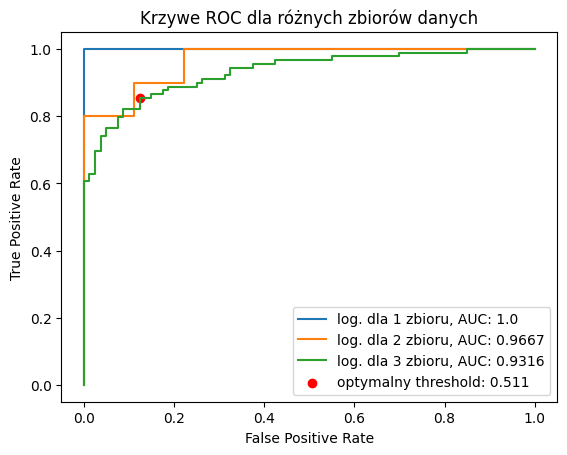

In [30]:
# predykcja na zbiorze walidacyjnym, krzywe roc i wartości AUC
from sklearn.metrics import roc_curve, roc_auc_score, auc, confusion_matrix
predicted_classes_logistic = log_r.predict(X_valid)
pred1 = log_r.predict_proba(X_valid)
pred2 = log_r2.predict_proba(X2_valid)
pred3 = log_r3.predict_proba(X3_valid)

fpr, tpr, thresholds = roc_curve(y_valid, pred1[:,1], pos_label=1)
plt.plot(fpr,tpr,label="log. dla 1 zbioru, AUC: "+str(round(roc_auc_score(y_valid, pred1[:,1]), 4)))

fpr, tpr, thresholds = roc_curve(y2_valid, pred2[:,1], pos_label=1)
plt.plot(fpr,tpr,label="log. dla 2 zbioru, AUC: "+str(round(roc_auc_score(y2_valid, pred2[:,1]), 4)))

fpr, tpr, thresholds = roc_curve(y3_valid, pred3[:,1], pos_label=1)
plt.plot(fpr,tpr,label="log. dla 3 zbioru, AUC: "+str(round(roc_auc_score(y3_valid, pred3[:,1]), 4)))

optimal_index = np.argmin((1-tpr)**2+fpr**2)
optimal_threshold = thresholds[optimal_index]


plt.scatter(fpr[optimal_index], tpr[optimal_index], marker='o', color='red', label= f"optymalny threshold: {round(optimal_threshold, 3)}")
plt.legend()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("Krzywe ROC dla różnych zbiorów danych")
plt.show()

In [31]:
# predykcja na zbiorze testowym i miary jakości
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
pred_test= log_r3.predict_proba(X3_test)[:,1]
pred_test = pred_test > optimal_threshold
tp, fn, fp, tn = confusion_matrix(y3_test, pred_test).ravel()

print("accuracy: %0.3f" % (accuracy_score(y3_test, pred_test)))
print("recall: %0.3f" % (recall_score(y3_test, pred_test)))
print("precision: %0.3f" % (precision_score(y3_test, pred_test)))
print("f1 score: %0.3f" % (f1_score(y3_test, pred_test)))
print("sensitivity: %0.3f" % (tp/(tp+fn)))
print("specificity: %0.3f" % (tn/(tn+fp)))

accuracy: 0.844
recall: 0.832
precision: 0.840
f1 score: 0.836
sensitivity: 0.856
specificity: 0.832


Would a different (than 0.5) threshold yield better results?

Threshold mówi jakie powinno być prawdopodobieństwo przynależenia do klasy 1 wyznaczone przez model regresji logistycznej, żeby ta obserwacja była przypisana do tej klasy. Widzimy, że jego wybór wiąże się z wyborem, czy zależy nam na tym, żeby znaleźć jak najwięcej potencjalnych rekordów z klasy 1, czy może chcemy być przy tej klasyfikacji ostrożni i większe ryzyko dla nas niesie przypisanie błędne klasy 1 niż jej nieprzypisanie, gdy powinniśmy to zrobić. Istotnie, w pierwszym przypadku ustalilibyśmy threshold mniejszy od 0.5, natomiast w drugim większy, aby mieć większą pewność, iż nie popełnilibyśmy błędu polegającego na przyporządkowaniu klasy 1 obserwacji o klasie 0. Tak sklasyfikowane obserwacje nazywamy „false positive”  (przyjmując, że 1 oznacza wynik pozytywny). Stąd różne wielkości threshold stanowią odpowiedzi na konkretne problemy i zależą od tego na co kładziemy nacisk. Zwróćmy również uwagę na to, że są różne metryki oceniające jakość modelu w zależności od naszych potrzeb. Przeanalizujmy jak threshold wpływa na ocenę.  

How does shifting the threshold affect the trade-off between sensitivity and specificity?

Czułość (sensitivity) to wielkość widoczna na pionowej osi wykresu krzywej ROC powyżej. Jest ona zatem równa liczbie dobrze sklasyfikowanych pozytywów do liczby wszystkich elementów z klasy 1. Oczywiście im mniejszy threshold tym większą cześć obserwacji pozytywnych wykryjemy.
Inną miarą jest jest swoistość (specificity). mierzy jaki ułamek obserwacji negatynych sklasyfikowaliśmy poprawnie. Jest zatem równy 1 - 'False Positive Rate'. Mocniejszy warunek należenia do klasy 1 pozwala więcej obserwacji przyporządkować do klasy 2. Posumowując, zwiększając threshold wynajdujemy większą część negatywów, ale przez to też potencjalnie przyporządkowujemy pozytywy do klasy 0. Na ogół nie jest możliwe uniknięcie obu rodzajów błędu jednocześnie wyjątkiem jest niebieska krzywa roc, w jej przypadku idealnie sklasyfikowaliśmy dane. W związku z rzadkością takiej klasyfikacji, musimy, na ogół, decydować jaka jest istotność błędów w analizowanym problemie.

Is higher specificity more valuable than higher sensitivity in certain contexts? Or maybe the other way around? Does the best threshold depend on the task? (discuss cases like disease detection vs. spam filtering)

Tak, na podstawie wcześniejszych obserwacji stwierdzamy, że wybór miary powinien być adekwatny do postawionego celu. W szczególności powinien zależeć od tego jakiego błędu przy predykcji chcemy się w większym stopniu ustrzec. W przypadku np. wybierania jednostek do badań na daną chorobę chcemy ustrzec się wykluczenia choroby u osoby w rzeczywistości chorej, więc prawdopodobnie skupimy się na maksymalizowaniu czułości, natomiast wykrywając spam nie chcemy ukryć ważnej informacji - posłużymy się miarą swoistości.

How does a ROC curve help in this process?

Krzywa ta pozwala sprawdzić jaki poziom jednej z tych miar możemy otrzymać utrzymując drugą z nich na danym poziomie. W szczególności pozwala dobrać odpowiedni threshold tak, żeby model miał najlepszą drugą miarę spośród modeli o tym samym poziomie w ważniejszej z miar dla tego problemu.

How do you select the optimal threshold using the ROC curve?

Jest wiele rożnych możliwości doboru threshold'u w zależności od tego czego wymagamy od modelu. Przykładowo, jeśli zależy nam na wysokim stosunku czułość/swoistość to wybierzemy punkt blisko prawego górnego rogu wykresu krzywej roc. Jasne jest jednak, że należy wybrać punkt w narożniku krzywej roc (O najmniejszej wartości na osi x przy ustalonym poziomie czułości).
W przypadku wyboru thresholdu dla danych trzecich wybraliśmy punkt pośredni, chcąc uzyskać dobre wyniki obu miar. W tym celu wybraliśmy punkt wykresu będący najbliżej lewego górnego rogu.

What is the AUC metric and how is it useful?

AUC jest zdefiniowana jako pole pod krzywą roc. Mierzy ona globalnie jakość modelu nie korzystając z miar czułości i swoistości przy ustalonym poziomie odcięcia, a z ich wyników dla wszystkich takich poziomów. Można ją interpretować także jako średnią miarę czułości przy zmieniajacej się mierze swoistości.